In [1]:
!conda install -c conda-forge geopy --yes 

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [2]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import display
from geopy.geocoders import Nominatim

In [3]:
boroughs = pd.read_csv('boroughs.csv', header = None)
boroughs.columns = ['Borough']

In [4]:
def borough_locat_frame(boroughs, agent):
    
    frame = pd.DataFrame(np.zeros((len(boroughs), 3)))
    geolocator = Nominatim(user_agent = agent)
    
    for i, borough in enumerate(boroughs.values):
        location = geolocator.geocode(borough +', London, UK')
        
        frame.iloc[i, 0] = borough
        frame.iloc[i, 1] = location.latitude
        frame.iloc[i, 2] = location.longitude
        
    frame.columns = ['Borough', 'Latitude', 'Longitude'] 
        
    return frame
    

In [5]:
user_agent="jeffreysaid@hotmail.com"
bor_frame = borough_locat_frame(boroughs, user_agent)

In [6]:
bor_frame.head()

,Borough,Latitude,Longitude
0,City of London,51.515618,-0.091998
1,Barking and Dagenham,51.554117,0.150504
2,Barnet,51.653090,-0.200226
3,Bexley,51.441679,0.150488
4,Brent,51.563826,-0.275760


In [7]:
bor_frame.to_csv('Borough_Geo_Locations.csv')

In [8]:
CLIENT_ID = '0ZWEKPOSZMJ42IP2FK5P4YF2C1ZW51YYLJ2V4RENT3OMP4PX' # your Foursquare ID
CLIENT_SECRET = 'UF1DT3CFB4ZAEQZ1G2ZJXHATPN2HHUTMPJCCETHJLWCXO1DC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0ZWEKPOSZMJ42IP2FK5P4YF2C1ZW51YYLJ2V4RENT3OMP4PX
CLIENT_SECRET:UF1DT3CFB4ZAEQZ1G2ZJXHATPN2HHUTMPJCCETHJLWCXO1DC


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
radius = 1000
LIMIT = 500
london_venues = getNearbyVenues(names=bor_frame['Borough'],
                                 latitudes=bor_frame['Latitude'],
                                 longitudes=bor_frame['Longitude']
                                )

City of London
Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston-upon-Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond-upon-Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [11]:
london_venues.shape

(1383, 7)

In [12]:
london_venues.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,City of London,51.515618,-0.091998,Goodman Steak House Restaurant,51.514398,-0.090745,Steakhouse
1,City of London,51.515618,-0.091998,The Ned Hotel,51.513755,-0.090067,Hotel
2,City of London,51.515618,-0.091998,The Merchant House,51.513264,-0.093039,Cocktail Bar
3,City of London,51.515618,-0.091998,Hawksmoor Guildhall,51.515498,-0.090849,Steakhouse
4,City of London,51.515618,-0.091998,City Càphê,51.514750,-0.091545,Vietnamese Restaurant


In [13]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
print(london_onehot.shape)
# add neighborhood column back to dataframe
london_onehot.insert(0, 'Borough', london_venues['Borough'].values)

(1383, 230)


In [48]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head(10)

,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Barking and Dagenham,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
1,Barnet,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
2,Bexley,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
3,Brent,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
4,Bromley,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.023256,...,0.023256,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
5,Camden,0.0,0.011364,0.011364,0.0,0.0,0.000000,0.0,0.0,0.022727,...,0.000000,0.00,0.022727,0.000000,0.022727,0.000000,0.0,0.0,0.000000,0.00
6,City of London,0.0,0.000000,0.000000,0.0,0.0,0.030000,0.0,0.0,0.000000,...,0.000000,0.01,0.000000,0.000000,0.020000,0.030000,0.0,0.0,0.000000,0.02
7,Croydon,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00
8,Ealing,0.0,0.000000,0.010526,0.0,0.0,0.010526,0.0,0.0,0.010526,...,0.000000,0.00,0.000000,0.010526,0.021053,0.010526,0.0,0.0,0.000000,0.00
9,Enfield,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.034483,0.00,0.000000,0.017241,0.000000,0.000000,0.0,0.0,0.017241,0.00


In [15]:
rest_list = [rest for rest in london_grouped.columns if 
             'Restaurant' in rest and rest != 'Restaurant' or
             'Shop' in rest or 'Joint' in rest
            ]
print(london_grouped.shape)
print(len(rest_list)/london_grouped.shape[1])
#for venue in london_grouped.columns: print(venue)

(33, 231)
0.341991341991342


In [16]:
borough_div = []

for i, borough in enumerate(london_grouped['Borough']):
    rests = london_grouped.loc[i, rest_list] > 0.000001
    borough_div.append(sum(rests))

borough_div = pd.DataFrame(borough_div)
borough_div.index = london_grouped['Borough']
borough_div.columns = ['Score']
    
borough_div.sort_values(by = ['Score'], inplace = True)

In [51]:
london_cluster = normalize(london_grouped.drop('Borough', 1))
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_cluster)

# check cluster labels generated for each row in the dataframe
sel = [i for i, borough in enumerate(london_grouped['Borough'].values)]
london_out = bor_frame.loc[sel, :]
london_out = london_out.assign(Label = kmeans.labels_)
london_out.iloc[:, [0,3]].sort_values(by = ['Label']).to_csv('categories.csv')

In [18]:
lonlab = london_out['Label']
lonlab.index = london_out['Borough']
lonlab.columns = ['Label']
borough_div['Label'] = lonlab.loc[borough_div.index, ]
borough_div.tail(11)

,Score,Label
Borough,,
Kensington and Chelsea,12,0
Havering,13,1
Lambeth,14,0
Haringey,14,1
City of London,18,1
Camden,21,0
Hammersmith and Fulham,21,0
Southwark,21,0
Islington,22,1


In [19]:
# create map

latitude  = 51.5074
longitude = 0.1278


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_out['Latitude'], london_out['Longitude'], 
                                  london_out['Borough'], london_out['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [20]:
london_out.to_csv('london_clustered_five.csv')

In [21]:
steaks = london_grouped[london_grouped['Steakhouse'] > 0.0][['Borough', 'Steakhouse']]
steaks.sort_values(['Steakhouse'], inplace = True, ascending = False)
steaks

,Borough,Steakhouse
6,City of London,0.030000
21,Lambeth,0.016949
18,Islington,0.015152
8,Ealing,0.010526
27,Southwark,0.010000


In [22]:
gyms = london_grouped[london_grouped['Gym'] > 0.0][['Borough', 'Gym']]
gyms.sort_values(['Gym'], inplace = True, ascending = False)
gyms

,Borough,Gym
22,Lewisham,0.036364
32,Westminster,0.023256
21,Lambeth,0.016949
12,Hammersmith and Fulham,0.010870
8,Ealing,0.010526
6,City of London,0.010000


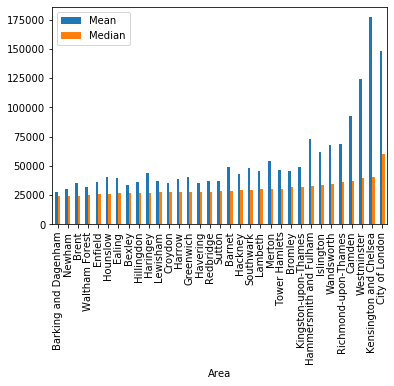

In [23]:
salaries = pd.read_csv('income-of-tax-payers.csv')
out_salaries = salaries.sort_values(['Median'])
out_salaries.index = out_salaries['Area']
out_salaries.drop('Area', axis = 1)
out_salaries[['Mean', 'Median']].plot(kind = 'bar')

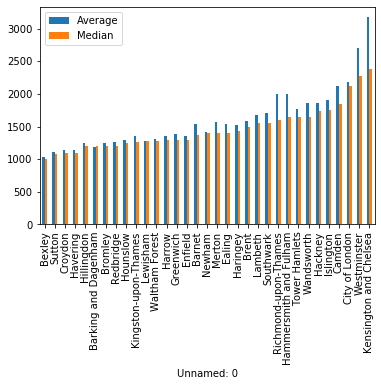

In [24]:
rents = pd.read_csv('rents_london.csv')
out_rents = rents.sort_values(['Median'])
out_rents.index = out_rents['Unnamed: 0']
out_rents.drop('Unnamed: 0', axis = 1)
out_rents[['Average', 'Median']].plot(kind = 'bar')

In [46]:
#lonlab = london_out['Label']
#lonlab.index = london_out['Borough']
#lonlab.columns = ['Label']
#borough_div['Label'] = lonlab.loc[borough_div.index, ]
rts = rents['Median']
rts.index = rents['Unnamed: 0']
rts.columns = ['Rent']
borough_div['Rent'] = rts.loc[borough_div.index, ]
print(borough_div[borough_div['Label'] == 0].sort_values(by = ['Rent']))
print(borough_div.sort_values(by = ['Score']).tail(11))


rts = salaries['Median']
rts.index = salaries['Area']
rts.columns = ['Salary']
borough_div['Salary'] = rts.loc[borough_div.index, ]
print(borough_div[borough_div['Label'] == 0].sort_values(by = ['Salary']))
print(borough_div.sort_values(by = ['Score']).tail(11))

                        Score  Label  Rent
Borough                                   
Bexley                      4      0  1000
Barking and Dagenham        0      0  1200
Hounslow                    6      0  1250
Kingston-upon-Thames       31      0  1258
Lewisham                    7      0  1275
Harrow                      4      0  1300
Enfield                    12      0  1300
Ealing                     26      0  1400
Brent                       3      0  1495
Lambeth                    14      0  1550
Southwark                  21      0  1560
Hammersmith and Fulham     21      0  1647
Wandsworth                 10      0  1650
Camden                     21      0  1842
Kensington and Chelsea     12      0  2383
                        Score  Label  Rent
Borough                                   
Kensington and Chelsea     12      0  2383
Havering                   13      1  1100
Lambeth                    14      0  1550
Haringey                   14      1  1425
City of Lon

In [26]:
london_out_str = london_out.copy()
london_out_str['Label'] = pd.DataFrame(london_out_str['Label'].values.astype('str'))
london_out_onehot = pd.get_dummies(london_out_str[['Label']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
#london_onehot.insert(0, 'Borough', london_venues['Borough'].values)


reg = LinearRegression()
reg.fit(np.matrix(london_out_onehot), rents['Median'].values)
print(reg.score(np.matrix(london_out_onehot), rents['Median'].values))
print(reg.coef_)

0.0061832330089170995
[ 27.52380952  24.95238095 -52.47619048]


In [27]:
reg = LinearRegression()
reg.fit(np.matrix(london_out_onehot), salaries['Median'].values)
print(reg.score(np.matrix(london_out_onehot), salaries['Median'].values))
print(reg.coef_)

0.01401576432287066
[-803.25396825  874.84126984  -71.58730159]


In [28]:
labs_rent = london_out['Label']
for (x,y,z) in zip(salaries.index.values, labs_rent, salaries['Median']):
    print(x, y, z)

0 1 60000
1 0 23900
2 2 28700
3 0 26900
4 0 24700
5 1 32000
6 0 37300
7 1 27500
8 0 26700
9 0 26300
10 1 27600
11 1 29400
12 0 33200
13 1 27100
14 0 27600
15 1 27900
16 2 27100
17 0 26400
18 1 33400
19 0 40400
20 0 32400
21 0 29900
22 0 27300
23 2 30200
24 1 24100
25 1 28000
26 2 36100
27 0 29400
28 1 28200
29 1 30200
30 1 25500
31 0 34500
32 1 39700


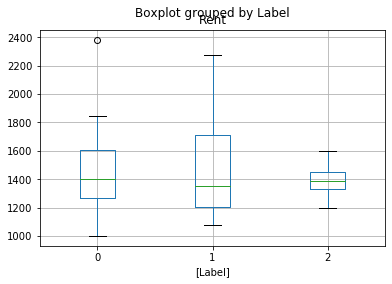

In [29]:
london_out_rent = pd.DataFrame(rents['Median'].values)
london_out_rent.insert(0, 'Label', london_out['Label'].values.astype(int))
london_out_rent.columns = ['Label', 'Rent']
london_out_rent.index = rents['Unnamed: 0']
london_out_rent.head()
london_out_rent.boxplot(by = 'Label')

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

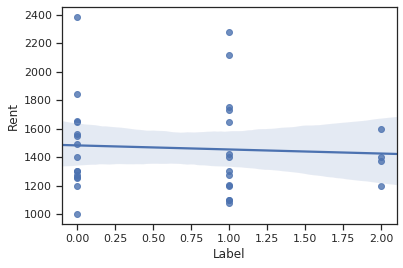

In [31]:
sns.regplot(x="Label", y="Rent", data=london_out_rent);

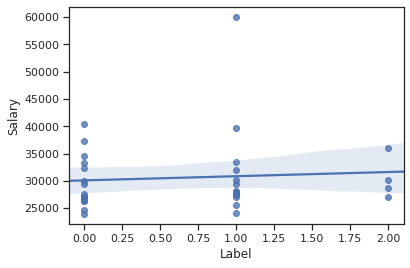

In [47]:
sns.regplot(x="Label", y="Salary", data=london_out_sal);

In [32]:
london_out_rent[london_out_rent['Label']==0]

,Label,Rent
Unnamed: 0,,
Barking and Dagenham,0,1200
Bexley,0,1000
Brent,0,1495
Camden,0,1842
Ealing,0,1400
Enfield,0,1300
Hammersmith and Fulham,0,1647
Harrow,0,1300
Hounslow,0,1250


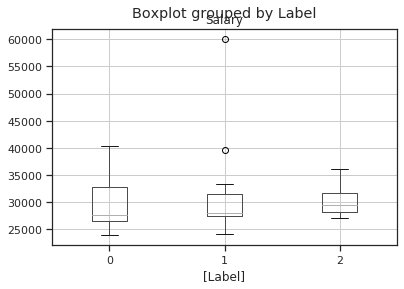

In [33]:
london_out_sal = pd.DataFrame(salaries['Median'].values)
london_out_sal.insert(0, 'Label', london_out['Label'].values.astype(int))
london_out_sal.index = salaries['Area']
london_out_sal.columns = ['Label', 'Salary']
london_out_sal.head()
london_out_sal.boxplot(by = 'Label')

#london_out_rent.boxplot()#plot(kind = 'scatter', x = 'Label', y = 'Rent')

In [34]:
london_out_sal[london_out_sal['Label']==0].sort_values(by = ['Salary'])

,Label,Salary
Area,,
Barking and Dagenham,0,23900
Brent,0,24700
Enfield,0,26300
Hounslow,0,26400
Ealing,0,26700
Bexley,0,26900
Lewisham,0,27300
Harrow,0,27600
Southwark,0,29400


In [35]:
london_out_rent[london_out_rent['Label']==0].sort_values(by = ['Rent'])

,Label,Rent
Unnamed: 0,,
Bexley,0,1000
Barking and Dagenham,0,1200
Hounslow,0,1250
Kingston-upon-Thames,0,1258
Lewisham,0,1275
Enfield,0,1300
Harrow,0,1300
Ealing,0,1400
Brent,0,1495


Kingston-upon-Thames deep dive 

In [36]:
kup = london_grouped[london_grouped['Borough'] == 'Kingston-upon-Thames'].iloc[:, 1:]

In [37]:
kup = kup.T

In [38]:
kup.sort_values(by = 20, ascending = False).head(10)

,20
Coffee Shop,0.09
Italian Restaurant,0.06
Clothing Store,0.06
Café,0.06
Pub,0.05
Department Store,0.03
Bakery,0.03
Ice Cream Shop,0.02
Sandwich Place,0.02
Burger Joint,0.02


In [39]:
# type your answer here
kupvenues = london_venues[london_venues['Borough'] == 'Kingston-upon-Thames']

In [40]:
kupvenues.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
913,Kingston-upon-Thames,51.409627,-0.306262,Rose Theatre,51.408557,-0.307327,Theater
914,Kingston-upon-Thames,51.409627,-0.306262,Kingston Market Place,51.409600,-0.306265,Market
915,Kingston-upon-Thames,51.409627,-0.306262,The Ram,51.408149,-0.307768,Pub
916,Kingston-upon-Thames,51.409627,-0.306262,Banquet Records,51.409080,-0.303382,Record Shop
917,Kingston-upon-Thames,51.409627,-0.306262,Woody's Bar & Kitchen,51.408436,-0.308465,Pub


In [41]:
(lat, long) = bor_frame[bor_frame['Borough'] == 'Kingston-upon-Thames'].iloc[:, 1:].values[0]


In [42]:

map_clusters = folium.Map(location=[lat, long], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)[1]
ys = [i + x + (i*x)**2 for i in range(kclusters)][1]
colors_array = cm.rainbow(np.linspace(0, 1, len([ys])))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, venue, cluster in zip(kupvenues['Venue Latitude'], kupvenues['Venue Longitude'], 
                                  kupvenues['Venue'], kupvenues['Venue Category']):
    label = folium.Popup(venue + ' - ' + cluster, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color='blue',
        fill_opacity=0.01).add_to(map_clusters)
map_clusters